In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import math
import bisect
import queue
np.set_printoptions(threshold=np.inf)

In [93]:
def heuristics_distance(node, end_node,n):
    """this function is computes the heuristic used in A*"""
    i, j = matrixindex(node, n)
    gi, gj = matrixindex(end_node, n)
    return math.fabs(i - gi) + math.fabs(j - gj)  #manhattan distance

In [94]:
def display_result(world, path):
    """
    This function displays a maze described in world_mat and a path inside the maze
    world_mat: a N_width x N_height matrix that contains the maze (0 for free path, > 10 for obstacle)
    path: a list of elements numbered as the graph (i.e. from 0 to N**2-1)
    """
    N_height,N_width = world.shape[:2]  #assign height and width
    display = world.copy()        ## create a copy of image
    for el in path:
        display[matrixindex(el,N_width)] = 120   ##assign grey color to path
    plt.figure(figsize=(15,15))
    plt.imshow(display, cmap='gray')
    
    
def listindex(i,j,N_width):
    """
    This function converts a (i,j) matrix entry index to a list index for matrix of size Nx
    """
    return N_width*i+j    ##converting to list index

def matrixindex(a,N_width):
    """
    This function converts a list entry a into a (i,j) matrix entry for matrix of size Nx,Ny
    """
    i = int(a/N_width) # the result of integer division
    j = int(a%N_width) # the  remainder of the division
    
    #needs only N_width
    return i,j


def create_graph(world_mat):
    """
    This functions takes a Nw x Nh matrix in entry and creates a graph and a map of costs
    Since we use lists, for a world_mat of size Nw x Nh, we associate to the entry [i,j] of world_map
    the index a=Nw*i + j of the list
    output:
        graph: a list of neighbors  (indexed as explained above)
        cost: a N**2 x  N**2 array. Each entry cost[i,j] contains the cost of transitioning from node i to node j
            it is infinite if there is no edge from i to j
    """
    """
    The "world_mat" passed is an image..word_mat[i,j] ; i is the hieght and j is the width
    """
    Nh,Nw = world_mat.shape[:2]
    graph = []
    near_obstacle = []               #array for checking proximity to obstacles
    almost_near = []
    threshold = 5
    area = [1,2]
    for i in range(Nh):  #goes top down --0 to bottom height
        for j in range(Nw):  #goes left right -- 0 to full width
            neigh = []  
            a1,a2,a3,a4 = 0,0,0,0            #markers....reset markers after every iteration
            b1,b2,b3,b4 = 0,0,0,0
            if(i < Nh-max(area)-1):
                if(world_mat[i+1,j]<threshold):  
                    neigh.append(Nw*(i+1)+j)
                for n in area:
                    if(world_mat[i+n,j]>threshold):   #if there is an obstacle closeby, set marker to 1
                        a1 = 1
                        
            if(i > max(area)):
                if(world_mat[i-1,j]<threshold):
                    neigh.append(Nw*(i-1)+j)
                for n in area:
                    if(world_mat[i-n,j]>threshold):  #if there is an obstacle closeby, set marker to 1
                        a2 = 1
                        
            if(j < Nw-max(area)):
                if(world_mat[i,j+1]<threshold):
                    neigh.append(Nw*i+j+1)
                for n in area:
                    if(world_mat[i,j+n]>threshold):   #if there is an obstacle closeby, set marker to 1
                        a3 = 1
                        
            if(j > max(area)):
                if(world_mat[i,j-1]<threshold):
                    neigh.append(Nw*i+j-1)
                for n in area:
                    if(world_mat[i,j-n]>threshold):    #if there is an obstacle closeby, set marker to 1
                        a4 = 1
                               
           #//////////////////////////////////////////////
            if(i < Nh-max(area) and j < Nw-max(area)):
                if(world_mat[i+1,j+1]<threshold):  # bottom right
                    neigh.append(Nw*(i+1)+j+1)  
                for n in area:
                    if(world_mat[i+n,j+n]>threshold):   #if there is an obstacle closeby, set marker to 1
                        b1 = 1
                    
            if(i > max(area) and j > max(area)):
                if(world_mat[i-1,j-1]<threshold): #top left
                    neigh.append(Nw*(i-1)+j-1)
                for n in area:
                    if(world_mat[i-n,j-n]>threshold):   #if there is an obstacle closeby, set marker to 1
                        b2 = 1
                    
            if(j < Nw-max(area) and i > max(area)):               
                if(world_mat[i-1,j+1]<threshold):   #bottom left
                    neigh.append(Nw*(i-1)+j+1)
                for n in area:
                    if(world_mat[i-n,j+n]>threshold):  #if there is an obstacle closeby, set marker to 1
                        b3 = 1
                    
            if(j > max(area) and i < Nh-max(area)):                    #top right
                if(world_mat[i+1,j-1]<threshold):
                    neigh.append(Nw*(i+1)+j-1)
                for n in area:    
                    if(world_mat[i+n,j-n]>threshold):    #if there is an obstacle closeby, set marker to 1
                        b4 = 1

                    
            near_obstacle.append(a1+a2+a3+a4+b1+b2+b3+b4)       #for every node, append the status of its proximity to obstacles
            graph.append(neigh)
    
   
    cost = np.ones([Nw*Nh,Nw*Nh]) * np.inf
    other_cost = np.ones([Nw*Nh,Nw*Nh]) * np.inf
    
    flatten_map = world_mat.ravel()
    near_obstacle = np.array(near_obstacle)
    near_obstacle = (near_obstacle > 0)            # convert to ones and zeros on which node is near obstacles
    
    is_obstacle = (flatten_map > threshold)          #nodes that are obstacles...obstacles present == true (shows obstacle locations)
    is_obstacle = np.array(is_obstacle)
    
    final_data = near_obstacle + is_obstacle     #add both list to get final list with nodes set to true
    final_data = (final_data > 0)
    
    cost = None

    for i in range(Nh*Nw):
        for j in graph[i]:
            if final_data[i] == True:    # give all the neighbors of obstacles a higher cost
                other_cost[i,j] = 10
            else:
                other_cost[i,j] = 1   #the cost of movement in any direction is 1  
    

    return graph, cost,other_cost

In [95]:
def AStar(graph, start_node, end_node, cost, heuristic,sw):
    """
    this function gets a graph, a start_node, end_node and cost list as entry
    and returns a path (list of nodes) as output
    it return an empty list in case of failure
    
    it follows the A* algorithm seen in class
    """
    #A star requires sorting
    
    # we initialize the algorithm
    open_set = [start_node]
    estimated_total_cost = [0]
    closed_set = []
    past_cost = np.ones(len(graph)) * np.inf
    past_cost[start_node] = 0
    parent = [-1] * (len(graph))
    count = 0
    while open_set:
        count += 1
        current = open_set.pop(0)
        estimated_total_cost.pop(0)
        closed_set.append(current)
        if current == end_node:
            print('success')
            path = []
            while current!= start_node:
                path.append(current)
                current = parent[current]
            path.append(current)
            print('cost = ' + str(past_cost[int(end_node)]))
            return path, count
        for child in graph[current]:
            if child not in closed_set:
                tentative_past_cost = past_cost[current] + cost[current,child]
                if tentative_past_cost < past_cost[child]:
                    past_cost[child] = tentative_past_cost
                    parent[child] = current
                    est = past_cost[child]
                    if child != end_node:
                        est = est + heuristic(child,end_node,sw) #+hint(math.sqrt(len(graph))),end_nodeeuristic cost to go  int(math.sqrt(len(graph)))
                    if child in open_set:
                        s = open_set.index(child)
                        open_set.pop(s)
                        estimated_total_cost.pop(s)
                    index = bisect.bisect(estimated_total_cost, est)
                    open_set.insert(index, child)
                    estimated_total_cost.insert(index, est)
    print('Failure')
    return [], count

In [96]:
def flip_mask(img_array):
    new_array = []
    for img in img_array:
        new_img = cv2.bitwise_not(img)
        new_array.append(new_img)
    return new_array

In [97]:
def stitch_images(homography_list,img_array):
    b_y, b_x, stitched, translated_H = 0, 0, 0, 0
    img_array = flip_mask(img_array)
    a = img_array[0]
    for i, homography in enumerate(homography_list):
        b = img_array[i+1]

        # center of source image
        center_pt = [a.shape[1] // 2, a.shape[0] // 2, 1]

        # find where center of source image will be after warping without comepensating for any offset
        warped_pt = np.dot(homography, center_pt)
        warped_pt = [x / warped_pt[2] for x in warped_pt]
        # print("passing")
        inc = 3
        cond = True
        print("starting while",i)
        # while cond:
        # warping output image size # center of warping output image
        stitched_frame_size = tuple(int(inc * x) for x in a.shape[:2])
        w, h = stitched_frame_size
        if len(a.shape) == 3:
            im_copy = np.zeros((w, h, 3), np.uint8)
        else:
            im_copy = np.zeros((w, h, 1), np.uint8)

        # calculate offset for translation of warped image  ...find the offset to the center of the blank image
        x_offset = stitched_frame_size[0] / 2 - warped_pt[0]
        y_offset = stitched_frame_size[1] / 2 - warped_pt[1]

        # translation matrix
        Trans = np.array([[1, 0, x_offset], [0, 1, y_offset], [0, 0, 1]])
        # translate tomography matrix
        translated_H = np.dot(Trans, homography)

        # get the location to add the other stitched image
        b_x = int(x_offset)
        b_y = int(y_offset)
        print("in loop")
        hold = False
        try:
            hold = False
            stitched = cv2.warpPerspective(a, translated_H, stitched_frame_size)
            if i == 0:
                stitched[b_y:b.shape[0] + b_y, b_x:b.shape[1] + b_x] = b  # on the first image match use this
            else:
                im_copy[b_y:b.shape[0] + b_y, b_x:b.shape[1] + b_x] = b  # check sizing using blank image to get the best image size
        except ValueError as e:
            inc += 3
            hold = True
#         if not hold:
#             break


        hold_img = stitched[b_y:b.shape[0] + b_y, b_x:b.shape[1] + b_x]  # create roi
        # Now create a mask of logo and create its inverse mask also
        new2_gray = cv2.cvtColor(hold_img, cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(new2_gray, 10, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
        # Now black-out the area of logo in ROI
        img1_bg = cv2.bitwise_and(hold_img, hold_img, mask=mask)

        # Take only region of logo from logo image.
        img2_fg = cv2.bitwise_and(b, b, mask=mask_inv)
        # Put logo in ROI and modify the main image

        dst = cv2.add(img1_bg, img2_fg)
        stitched[b_y:b.shape[0] + b_y, b_x:b.shape[1] + b_x] = dst

        # cropping function
        # 2d ..x,y format... clockwise..
        a_sizes = [[0, 0, 1],  # this should be the warped image
                   [a.shape[1], 0, 1],
                   [a.shape[1], a.shape[0], 1],
                   [0, a.shape[0], 1]]

        b_sizes = [[b_x, b_y],  # non warped image
                   [b.shape[1] + b_x, b_y],
                   [b.shape[1] + b_x, b.shape[0] + b_y],
                   [b_x, b.shape[0] + b_y]]

        new_pts_warped = []
        for pt in a_sizes:  # find the new warped location points of the warped image
            warped_pt = np.dot(translated_H, pt)
            warped_pt = [x / warped_pt[2] for x in warped_pt]
            new_pts_warped.append(warped_pt)

        new_pts_warped = np.array(new_pts_warped)[0:, 0:2]  # get the first 2 columns since the third column is just ones
        non_warped = np.array(b_sizes)

        all_pts = np.concatenate((new_pts_warped, non_warped))
        x = int(min(all_pts[:, 0]))  # get the min x
        xw = int(max(all_pts[:, 0]))  # get the max x
        y = int(min(all_pts[:, 1]))  # get the min y
        yh = int(max(all_pts[:, 1]))  # get the max y
        stitched = stitched[y:yh, x:xw]  # crop image
        print("updating")
        a = stitched    #assign final stitch to 'a'
    
    final_stitch = cv2.bitwise_not(a)
#     final_stitch = flip_mask(final_stitch)
#     final_stitch = final_stitch[0]
    return final_stitch

In [98]:
homo1 = "homography_list_3"
hm1 = open(homo1, 'rb')  # Open the file
homography_list = pickle.load(hm1)  # Assign the recreated object

In [86]:
# im1 =cv2.imread("save_imgs/camera1.png")
# im2 = cv2.imread("save_imgs/camera2.png")
# im3 = cv2.imread("save_imgs/camera3.png")
# im4 = cv2.imread("save_imgs/camera4.png")

# m1 =cv2.imread("save_imgs/mask1.png")
# m2 =cv2.imread("save_imgs/mask2.png")
# m3 = cv2.imread("save_imgs/mask3.png")
# m4 = cv2.imread("save_imgs/mask4.png")
# m5 =cv2.imread("save_imgs/mask5.png")
# m6 =cv2.imread("save_imgs/mask6.png")
# m7 = cv2.imread("save_imgs/mask7.png")
# m8 = cv2.imread("save_imgs/mask8.png")
# m9 =cv2.imread("save_imgs/mask9.png")
# m10 =cv2.imread("save_imgs/mask10.png")
# m11 = cv2.imread("save_imgs/mask11.png")
# m12 = cv2.imread("save_imgs/mask12.png")
# mask_imgs = [m1, m2, m3,m4,m5,m6,m7,m8,m9,m10,m11,m12]
# real_imgs = [im1,im2,im3,im4]
# img_array = mask_imgs.copy()

starting while 0
in loop
updating
starting while 1
in loop
updating
starting while 2
in loop
updating
starting while 3
in loop
updating
starting while 4
in loop
updating
starting while 5
in loop
updating
starting while 6
in loop
updating
starting while 7
in loop
updating
starting while 8
in loop
updating
starting while 9
in loop
updating
starting while 10
in loop
updating


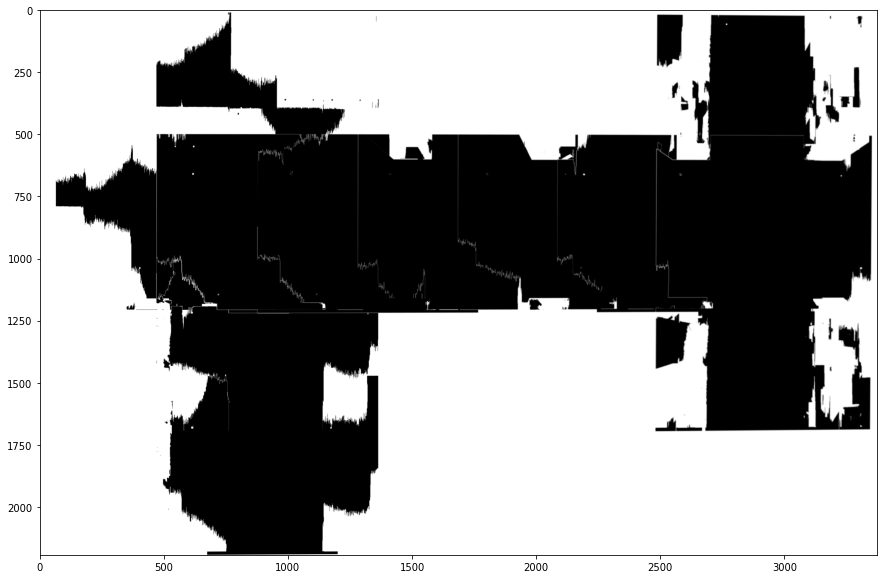

In [91]:
final_stitch = stitch_images(homography_list,mask_imgs)
plt.figure(figsize=(15,15))
plt.imshow(final_stitch)

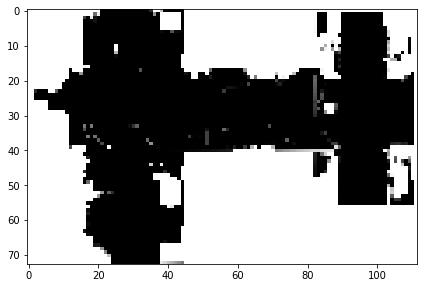

In [103]:
# I could also save the subpixel info before the scale and add it later
final_stitch = cv2.imread("save_imgs/final_img.png")
# temp = img.copy()
# img_resize_clear = img.copy()
# cv2.circle(temp,pt1,6,(255,0,0),-1)
# cv2.circle(temp,pt2,6,(0,255,0),-1)

img = final_stitch.copy()

h,w = img.shape[:2]
scale = 30
sh,sw = round(h/scale),round(w/scale)
temp_resize= cv2.resize(img,(sw,sh))


# plt.figure(figsize=(20,20))
# plt.subplot(1,2,1)
# plt.imshow(temp_resize)

# spt1 = (72,160)       #x,y ##pt1/10
# spt2 = (20,80)         

spt1 = (100,50)       #x,y ##pt1/10
spt2 = (20,20)         ##pt2/10

# cv2.circle(temp_resize,spt1,1,(255,0,0),-1)
# cv2.circle(temp_resize,spt2,1,(0,255,0),-1)

# print(h/scale,w/scale)
# print(temp_resize.shape)

plt.figure(figsize=(7,7))
plt.imshow(temp_resize)

success
cost = 103.0
1.416853904724121


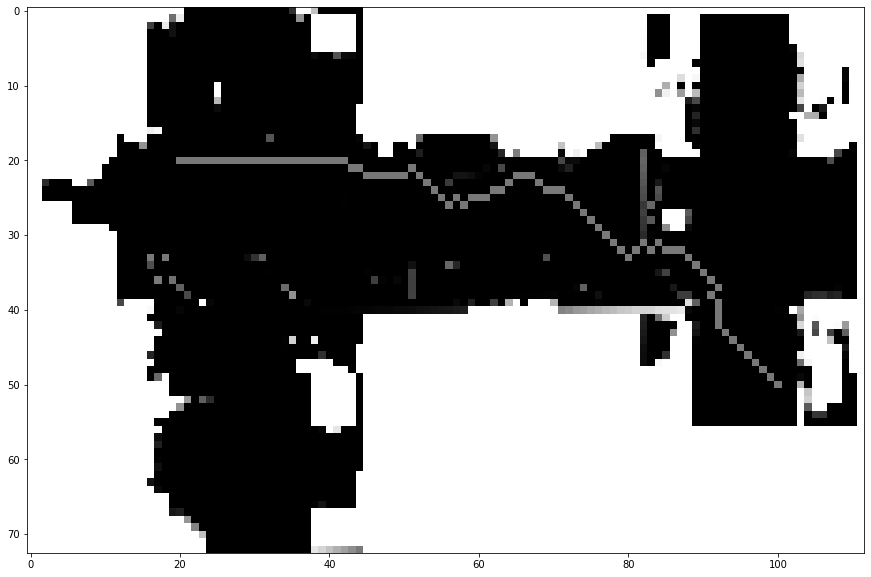

In [104]:
start = time.time()
temp_resize = cv2.cvtColor(temp_resize,cv2.COLOR_BGR2GRAY)
graph,cost,other_cost = create_graph(temp_resize)
start_node = listindex(spt1[1],spt1[0],sw)
end_node = listindex(spt2[1],spt2[0],sw)
path, count = AStar(graph,start_node,end_node,other_cost,heuristics_distance,sw)
display_result(temp_resize, path)
end = time.time()
print(end - start)

True

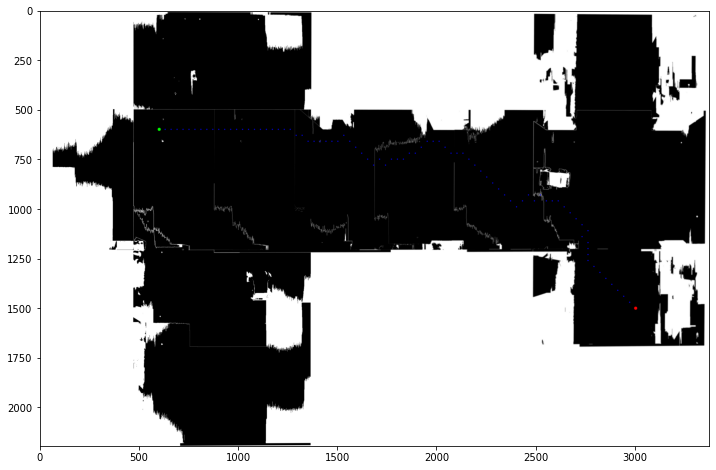

In [118]:
upscaled_path = np.array([matrixindex(node,sw) for node in path])*scale

hold = img.copy()
for x,y in upscaled_path:
    cv2.circle(hold,(y,x),3,(0,0,255),-1)

up_spt1 = tuple([z * scale for z in spt1 ])
up_spt2 = tuple([z * scale for z in spt2 ])
cv2.circle(hold,up_spt1,8,(255,0,0),-1)
cv2.circle(hold,up_spt2,8,(0,255,0),-1)
plt.figure(figsize=(12,12))
plt.imshow(hold)
cv2.imwrite("save_imgs/final_path.png", hold)

In [110]:
up_spt1 = tuple([z * scale for z in spt1 ])
up_spt2 = tuple([z * scale for z in spt2 ])
print(y)

(3000, 1500)
